In [194]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Load Data

In [195]:
df = pd.read_csv('housing_data_cleaned.csv')

In [196]:
df.head()

,Unnamed: 0,Zip_Code,Dwelling_Type,Nr_Bedrooms,Nr_Bathrooms,Approx_SQFT,Price_per_SqFt,Dwelling_Styles,Year_Built,Approx_Lot_SqFt,Pool,HOA_Fee,Land_Lease_Fee,Clubhouse_Rec_Room,Basement,RV_Gate,List_Price,Sold_Price,Building_Style,Gated_Community,Workout_Facility,Garage_Spaces,Carport_Spaces,Loan_Type,Payment_Type,HOA_Missing,Buyer_Concession,Seller_Concession,diff_List_Sold
0,0,85003,AF,1,1.0,720,340.28,Stacked,1964,652,Community,567.00,N,Yes,N,Yes,247000,245000,High Rise,Yes,Yes,0.0,1.0,Conventional,Fixed,0,0.0,7410.00,-2000
1,1,85003,LS,1,1.0,755,430.46,Stacked,2005,751,Private,631.00,N,Yes,N,Yes,335000,325000,High Rise,Yes,Yes,0.0,0.0,VA,Fixed,0,0.0,0.00,-10000
2,2,85003,SF,4,3.0,3415,439.23,Detached,1940,11696,no_pool,555.63,N,Yes,Y,Yes,1595000,1500000,High Rise,Yes,Yes,2.0,0.0,Conventional,Fixed,0,0.0,0.00,-95000
3,3,85003,AF,1,1.0,710,436.61,Stacked,2005,0,Community,671.17,N,Yes,N,Yes,315000,310000,High Rise,Yes,Yes,0.0,0.0,Conventional,Adjustable,0,0.0,6000.00,-5000
4,4,85003,AF,2,2.5,1510,314.56,Stacked,2007,654,Community,567.93,N,Yes,N,No,469900,475000,High Rise,No,Yes,2.0,0.0,Conventional,Fixed,0,0.0,17621.25,5100


In [197]:
df.columns


Index(['Unnamed: 0', 'Zip_Code', 'Dwelling_Type', 'Nr_Bedrooms',
       'Nr_Bathrooms', 'Approx_SQFT', 'Price_per_SqFt', 'Dwelling_Styles',
       'Year_Built', 'Approx_Lot_SqFt', 'Pool', 'HOA_Fee', 'Land_Lease_Fee',
       'Clubhouse_Rec_Room', 'Basement', 'RV_Gate', 'List_Price', 'Sold_Price',
       'Building_Style', 'Gated_Community', 'Workout_Facility',
       'Garage_Spaces', 'Carport_Spaces', 'Loan_Type', 'Payment_Type',
       'HOA_Missing', 'Buyer_Concession', 'Seller_Concession',
       'diff_List_Sold'],
      dtype='object')

In [198]:
df.dtypes

Unnamed: 0              int64
Zip_Code                int64
Dwelling_Type          object
Nr_Bedrooms             int64
Nr_Bathrooms          float64
Approx_SQFT             int64
Price_per_SqFt        float64
Dwelling_Styles        object
Year_Built              int64
Approx_Lot_SqFt         int64
Pool                   object
HOA_Fee               float64
Land_Lease_Fee         object
Clubhouse_Rec_Room     object
Basement               object
RV_Gate                object
List_Price              int64
Sold_Price              int64
Building_Style         object
Gated_Community        object
Workout_Facility       object
Garage_Spaces         float64
Carport_Spaces        float64
Loan_Type              object
Payment_Type           object
HOA_Missing             int64
Buyer_Concession      float64
Seller_Concession     float64
diff_List_Sold          int64
dtype: object

In [199]:
# dropping columns 'List_Price', and 'diff_List_Sold' conducive to data leakage
columns_to_drop = ['List_Price','diff_List_Sold','Price_per_SqFt', 'Unnamed: 0']

df.drop(columns_to_drop, axis=1, inplace=True)

**Find if any column contains NaN values** -- looks like 'HOA_Fee' contains NaN values

In [200]:
df.dtypes

Zip_Code                int64
Dwelling_Type          object
Nr_Bedrooms             int64
Nr_Bathrooms          float64
Approx_SQFT             int64
Dwelling_Styles        object
Year_Built              int64
Approx_Lot_SqFt         int64
Pool                   object
HOA_Fee               float64
Land_Lease_Fee         object
Clubhouse_Rec_Room     object
Basement               object
RV_Gate                object
Sold_Price              int64
Building_Style         object
Gated_Community        object
Workout_Facility       object
Garage_Spaces         float64
Carport_Spaces        float64
Loan_Type              object
Payment_Type           object
HOA_Missing             int64
Buyer_Concession      float64
Seller_Concession     float64
dtype: object

In [201]:
df.columns[df.isnull().any()].tolist()

['HOA_Fee']

In [202]:
# replace all NaN values with 0 in HOA_Fee column
df['HOA_Fee'] = df['HOA_Fee'].fillna(0)  

In [203]:
# sanity check for Nan values. 
df.columns[df.isnull().any()].tolist()
# it looks good

[]

### 1. Turn categorical values in numerical using get_dummies

In [204]:
only_objects = df.select_dtypes('object').info()  # there are 12 columns of object type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Dwelling_Type       3117 non-null   object
 1   Dwelling_Styles     3117 non-null   object
 2   Pool                3117 non-null   object
 3   Land_Lease_Fee      3117 non-null   object
 4   Clubhouse_Rec_Room  3117 non-null   object
 5   Basement            3117 non-null   object
 6   RV_Gate             3117 non-null   object
 7   Building_Style      3117 non-null   object
 8   Gated_Community     3117 non-null   object
 9   Workout_Facility    3117 non-null   object
 10  Loan_Type           3117 non-null   object
 11  Payment_Type        3117 non-null   object
dtypes: object(12)
memory usage: 292.3+ KB


In [205]:
df = pd.get_dummies(df,columns=['Dwelling_Type'], dtype='int', prefix='Type')
df = pd.get_dummies(df,columns=['Dwelling_Styles'], dtype='int',prefix='Style')
df= pd.get_dummies(df,columns=['Pool'],dtype='int', prefix='Pool')
df= pd.get_dummies(df,columns=['Land_Lease_Fee'],dtype='int', prefix='Land')
df= pd.get_dummies(df,columns=['Clubhouse_Rec_Room'],dtype='int', prefix='Club')
df= pd.get_dummies(df,columns=['Basement'], dtype='int',prefix='Base')
df= pd.get_dummies(df,columns=['RV_Gate'], dtype='int', prefix='RV_Gate')
df= pd.get_dummies(df,columns=['Building_Style'],dtype='int', prefix='Bldg_style')
df= pd.get_dummies(df,columns=['Gated_Community'],dtype='int', prefix='Gated')
df= pd.get_dummies(df,columns=['Workout_Facility'],dtype='int', prefix='Fittness')
df= pd.get_dummies(df,columns=['Loan_Type'],dtype='int', prefix='Loan')
df= pd.get_dummies(df,columns=['Payment_Type'],dtype='int', prefix='Payment')


In [206]:
df.shape

(3117, 63)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zip_Code                           3117 non-null   int64  
 1   Nr_Bedrooms                        3117 non-null   int64  
 2   Nr_Bathrooms                       3117 non-null   float64
 3   Approx_SQFT                        3117 non-null   int64  
 4   Year_Built                         3117 non-null   int64  
 5   Approx_Lot_SqFt                    3117 non-null   int64  
 6   HOA_Fee                            3117 non-null   float64
 7   Sold_Price                         3117 non-null   int64  
 8   Garage_Spaces                      3117 non-null   float64
 9   Carport_Spaces                     3117 non-null   float64
 10  HOA_Missing                        3117 non-null   int64  
 11  Buyer_Concession                   3117 non-null   float

## 2. Train/Test Split

In [208]:
# manual checking for the partition sizes for 70/30 split
len(df) * .7, len(df) * .3

(2181.8999999999996, 935.0999999999999)

In [209]:
# partitioning the data into training and testing in 70/30 splits, with predicted value is "Sold_Price"

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Sold_Price'), 
                                                    df.Sold_Price, test_size=0.3, 
                                                    random_state=47)

In [210]:
# partition sizes are consistent with the manual partitioning sizes calculated above
X_train.shape, X_test.shape

((2181, 62), (936, 62))

In [211]:
y_train.shape, y_test.shape

((2181,), (936,))

In [212]:
# Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

Zip_Code                   int64
Nr_Bedrooms                int64
Nr_Bathrooms             float64
Approx_SQFT                int64
Year_Built                 int64
                          ...   
Payment_Fixed              int32
Payment_Graduated          int32
Payment_Interest Only      int32
Payment_Missing            int32
Payment_Other              int32
Length: 62, dtype: object

In [213]:
# Repeat this check for the test split in `X_test`
X_test.dtypes

Zip_Code                   int64
Nr_Bedrooms                int64
Nr_Bathrooms             float64
Approx_SQFT                int64
Year_Built                 int64
                          ...   
Payment_Fixed              int32
Payment_Graduated          int32
Payment_Interest Only      int32
Payment_Missing            int32
Payment_Other              int32
Length: 62, dtype: object

### Determine how good the mean is as a predictor. Consider "Average Sold Price" is the best guess

In [214]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

649888.3635946814

In [215]:
# Calculate same thing by fitting the dummy regressor on the training data and calling mean strategy
# Then print the object's `constant_` attribute and verify it's the same as the mean above

dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

DummyRegressor()

array([[649888.36359468]])

How good is this? How closely does this match, or explain, the actual values? Metrics will help answering these questions

### Metrics:  
### R-squared or coefficient of determination

In [216]:
# Manually Calculate the R^2 
def r_squared(y, ypred):
    """R-squared score.    
    Calculate the R-squared, or coefficient of determination, of the input.
    Arguments:
               y -- the observed values
               ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y)            # I know I could have used np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2)   # total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2)  # residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

Make the predictions by creating an array "y_tr_pred" of length equal to the size of the training set with each array element equal to the single value of the mean.

In [217]:
y_tr_pred_ = train_mean * np.ones(len(y_train)) # np.ones(len(y_train)) creates an array of ones with the same length as y_train
y_tr_pred_[:5]

array([649888.36359468, 649888.36359468, 649888.36359468, 649888.36359468,
       649888.36359468])

I can obtain same thing using the sklearn dummy regressor baseline model: dumb_reg = DummyRegressor(strategy='mean')

In [218]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([649888.36359468, 649888.36359468, 649888.36359468, 649888.36359468,
       649888.36359468])

The DummyRegressor produces exactly the same results and saves me from having to mess about broadcasting the mean (or whichever other statistic is called. It also gives an object with fit() and predict() methods as well, which can be used as conveniently as any other sklearn estimator.

In [219]:
r_squared(y_train, y_tr_pred)  # call r_squared function defined previosuly, using arguments y_train, y_tr_pred

0.0

As expected, if I use the average value as my prediction, I get an $R^2$ of zero _on the training set_. What if I use this "model" to predict unseen values from the test set? Of course, the "model" is trained on the training set; I still use the training set mean as my prediction.

In [220]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)  # call r_squared function defined previosuly, using arguments y_test, y_te_pred

-0.0078084421886748245

Performance on a test set is expected to be slightly worse than on the training set. As I'm getting an  𝑅2
  of zero on the training set, there's nowhere to go but negative!  -0.0078

Next: I use Metrics that summarise the difference between predicted and actual values which are mean absolute error and mean squared error.

This is very simply the average of the absolute errors:

$$MAE = \frac{1}{n}\sum_i^n|y_i - \hat{y}|$$

𝑦̂ 
  are our predicted values for the depended variable

In [221]:
#Calculate the MAE according to formula above

def mae(y, ypred):
    """Mean absolute error.    
    Calculate the mean absolute error of the arguments
    Arguments:
                  y -- the observed values
                  ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [222]:
mae(y_train, y_tr_pred)

347574.7837341418

In [223]:
mae(y_test, y_te_pred)  

313711.9215035054

#### the MAE was less when used on test set compared to train set, which is against what was expected.  Test set is unseen so we generally expect Test MAE to be higher as it more difficult to perform well on unseen data.
 It might happen "by chance" that the test set is relatively easier (than the training set) for the model to score higher accuracy hence leading to lower Test MAE. Running 1000 different train/test splits or cross validations would be some exploration methods to further analyze. For now, I continue with sklearn metrics.
 


Mean absolute error is one of the most intuitive of all the metrics, this essentially says that, on average, expect to be off by around $313711 if the guessed Sold_Price was based on an average of known values.

### Next metric: Mean Squared Error calculated below as :   

$$MSE = \frac{1}{n}\sum_i^n(y_i - \hat{y})^2$$

MSE is a common metric (and an important one internally for optimizing machine learning models), this is simply the average of the square of the errors:

In [224]:
# Calculate the MSE according to formula above

def mse(y, ypred):
    """Mean square error.     
    Calculate the mean square error of the arguments
    Arguments:
            y -- the observed values
            ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [225]:
mse(y_train, y_tr_pred)

407213445225.1448

In [226]:
mse(y_test, y_te_pred)

306122830945.3079

This result is consistent with the findings of MAE where against expectations, the MSE on test data was less than MSE on train data. Same conclusions apply here

To convert this back to the measurement space, take the square root, to form the root mean square error thus:

In [227]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([638132.78024651, 553283.68035331])

### sklearn.metrics: Calculate R-squared and Mean Absolute Error using sklearn.metrics

In [228]:
# R-squared
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0078084421886748245)

In [229]:
# Mean absolute error
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(347574.7837341418, 313711.9215035054)

In [230]:
# Mean Squarred error
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(407213445225.1448, 306122830945.3079)

In [231]:
# train set - sklearn
r2_score(y_train, y_tr_pred)

0.0

In [232]:
# test set - sklearn
r2_score(y_test, y_te_pred)

-0.0078084421886748245

Conclusion:  The two error metrics MSE and MAE are employed. The MSE is typically larger than MAE, it penalizes larger errors more (because of the squaring operation). On the other hand MAE is more robust to the outliers sinmce it considers absolute differences. Results are conforming with expectations.

## Initial Models:  
### Steps: 
#### 1)   Scaling, 
#### 2)    Train the model on the train split
#### 3)    Make predictions using the model on both train and test splits
#### 4)    Assess model performance

In [233]:
# As I have features measured in many different units, with numbers that vary by orders of magnitude, 
# I start off by scaling them to put them all on a consistent scale. The StandardScaler scales each feature to zero mean and 
# unit variance.

### 1) Scaling

In [234]:
# Call the StandardScaler`s fit method on `X_tr` to fit the scaler
# then use it's `transform()` method to apply the scaling to both the train and test split
# data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

StandardScaler()

### 2) Train the model on the train split

In [235]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

### 3)    Make predictions using the model on both train and test splits

In [236]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

### 4)    Assess model performance

In [237]:
# r^2 - train, test
result_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
result_r2

(0.6771457224800644, 0.6160530356312937)

In [238]:
# calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as I did above for R^2
# MAE - train, test
result_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
result_mae

(214235.10473472107, 193667.83518665595)

In [239]:
#And also I do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
result_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
result_mse

(131470602654.56798, 116624277734.9166)

### Pipelines

In [240]:
#Code task 17#
#Modify the `SelectKBest` step to use a value of 5 for k
pipe5 = make_pipeline( 
    StandardScaler(),
    SelectKBest(f_regression, k=5),
    LinearRegression()
)

In [241]:
type(pipe5)

sklearn.pipeline.Pipeline

In [242]:
hasattr(pipe5, 'fit'), hasattr(pipe5, 'predict')

(True, True)

In [243]:
pd.options.display.max_columns=None
X_train.describe()


,Zip_Code,Nr_Bedrooms,Nr_Bathrooms,Approx_SQFT,Year_Built,Approx_Lot_SqFt,HOA_Fee,Garage_Spaces,Carport_Spaces,HOA_Missing,Buyer_Concession,Seller_Concession,Type_AF,Type_GT,Type_LS,Type_MD,Type_MM,Type_PH,Type_SF,Type_TH,Style_Attached,Style_Detached,Style_Stacked,Pool_Both,Pool_Community,Pool_Private,Pool_no_pool,Land_N,Land_Y,Club_No,Club_Yes,Base_N,Base_Y,RV_Gate_No,RV_Gate_Yes,Bldg_style_2-3-4 Plex,Bldg_style_2-3-4 Plex · Clustered,Bldg_style_Clustered,Bldg_style_Clustered · High Rise,Bldg_style_High Rise,Bldg_style_Missing,Bldg_style_String,Gated_No,Gated_Yes,Fittness_No,Fittness_Yes,Loan_Carryback,Loan_Cash,Loan_Cash to Loan,Loan_Conventional,Loan_Exchange,Loan_FHA,Loan_Other,Loan_USDA,Loan_VA,Payment_Adjustable,Payment_Balloon,Payment_Fixed,Payment_Graduated,Payment_Interest Only,Payment_Missing,Payment_Other
count,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2.181000e+03,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.00000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000
mean,85171.525447,3.138010,2.341243,1973.842733,1993.134342,3.583340e+04,225.855488,1.732004,0.322788,0.294819,157.860844,4008.011667,0.070610,0.001376,0.000917,0.000459,0.058230,0.016506,0.745071,0.106832,0.138927,0.807428,0.053645,0.053645,0.370931,0.230628,0.344796,0.968363,0.031637,0.721229,0.278771,0.987620,0.012380,0.839065,0.160935,0.017423,0.000459,0.021550,0.000459,0.011004,0.929849,0.019257,0.777166,0.222834,0.803760,0.196240,0.004585,0.283356,0.000459,0.47868,0.001834,0.129757,0.059606,0.000459,0.041265,0.005502,0.004127,0.524989,0.000459,0.000917,0.304448,0.159560
std,113.077119,0.978545,0.808631,952.506808,19.857585,1.194884e+06,423.660600,1.274054,0.676695,0.456066,1799.396340,6524.291861,0.256231,0.037071,0.030275,0.021413,0.234232,0.127441,0.435921,0.308970,0.345950,0.394410,0.225368,0.225368,0.483165,0.421331,0.475411,0.175071,0.175071,0.448498,0.448498,0.110598,0.110598,0.367556,0.367556,0.130872,0.021413,0.145241,0.021413,0.104346,0.255460,0.137459,0.416243,0.416243,0.397243,0.397243,0.067573,0.450731,0.021413,0.49966,0.042796,0.336113,0.236809,0.021413,0.198949,0.073989,0.064120,0.499490,0.021413,0.030275,0.460279,0.366281
min,85003.000000,1.000000,1.000000,397.000000,1911.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,85044.000000,2.000000,2.000000,1335.000000,1980.000000,4.156000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,85207.000000,3.000000,2.000000,1790.000000,1995.000000,6.708000e+03,121.000000,2.000000,0.000000,0.000000,0

### Fit the pipeline

In [244]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe5.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001AD06C4DDA0>)),
                ('linearregression', LinearRegression())])

#### Make predictions on the train and test sets

In [245]:
y_tr_pred = pipe5.predict(X_train)
y_te_pred = pipe5.predict(X_test)

#### Assess performance

In [246]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6487095644198582, 0.59574265845152)

In [247]:
result_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
result_mae

(218657.65798696448, 199089.77869434387)

In [248]:
result_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
result_mse

(143050188547.23132, 122793575291.44106)

### Assessing performance using cross-validation

In [249]:
cv_results = cross_validate(pipe5, X_train, y_train, cv=5)

In [250]:
cv_scores = cv_results['test_score']
cv_scores

array([0.6891245 , 0.6951945 , 0.66614678, 0.58246098, 0.586157  ])

In [251]:
np.mean(cv_scores), np.std(cv_scores)

(0.6438167520294027, 0.049558597109610796)

In [252]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.54, 0.74])

### Hyperparameter search using GridSearchCV

In [253]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [254]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [255]:
lr_grid_cv = GridSearchCV(pipe5, param_grid=grid_params, cv=5, n_jobs=-1)

In [256]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k=5,
                                                    score_func=<function f_regression at 0x000001AD06C4DDA0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [257]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [258]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 8}

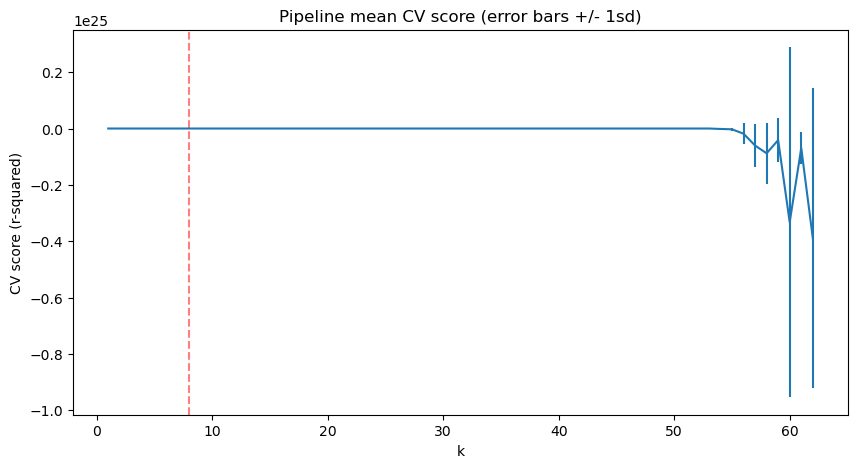

In [259]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [260]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [261]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Approx_SQFT       563235.043130
Nr_Bathrooms       84083.553228
Pool_Private       74571.110439
Pool_no_pool       32677.590669
Type_SF           -22289.515730
Carport_Spaces    -22609.821765
Garage_Spaces     -51154.683709
Nr_Bedrooms      -198498.692108
dtype: float64

### Random Forest Model

#### Define the pipeline

In [262]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

#### Fit and assess performance using cross-validation

In [263]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [264]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.75872084, 0.79563295, 0.80579217, 0.76491907, 0.68392753])

In [265]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.7617985121650713, 0.0428096035751959)

### Hyperparameter search using GridSearchCV

In [266]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        }
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [267]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [268]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [269]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 112,
 'standardscaler': StandardScaler()}

In [270]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.75956674, 0.79482516, 0.80483098, 0.76572066, 0.68357194])

In [271]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.7617030955243311, 0.04261987489274598)

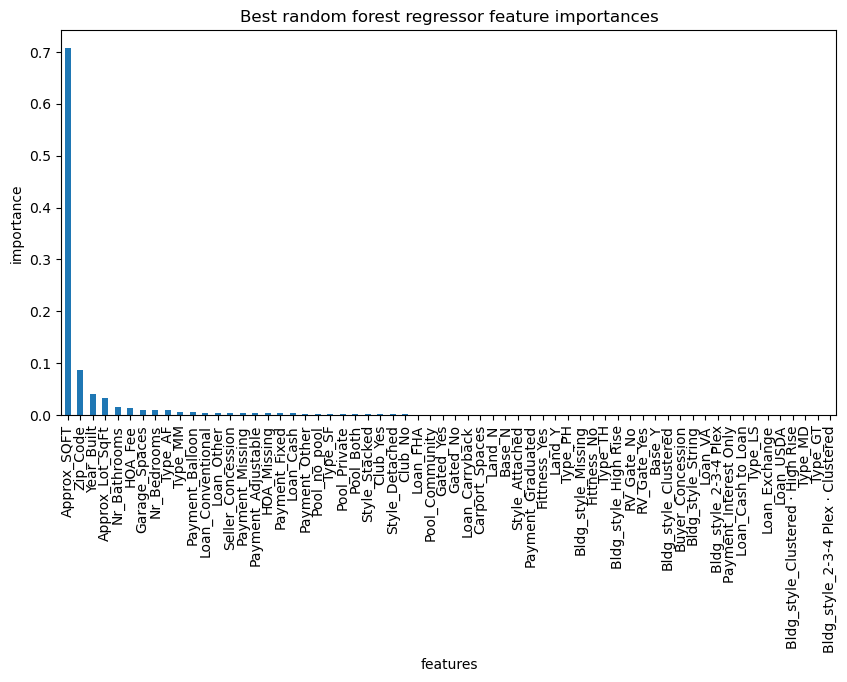

In [272]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The dominant top 8 features in Random Forest:

* Approx_SqFt
* Zip_Code
* Year_Built
* Approx_Lot_SqFt
* Nr_Bathrooms
* HOA_Fee
* Garage_Spaces
* Nr_Bedrooms


The Linear model top 8 best estimators are:

* Approx_SqFt
* Nr_Bathrooms
* Pool_Private
* Pool_no_pool
* Type_SF
* Carport_Spaces
* Garage_Spaces
* Nr_Bedrooms

The Random Forest model predictors make more sense intuitively, hence the better performance observed. 


### Final Model Selection

### Linear regression model performance

In [285]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [286]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(220084.8779068219, 8126.307459064367)

In [287]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

198864.60955780753

### Random forest regression model performance

In [288]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [289]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(129746.50228601458, 4100.221850180282)

In [290]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

101717.14808455433

## Conclusion

The random forest model has a lower cross-validation mean absolute error by almost $90000. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

### Data quantity assessment

In [291]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe5, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

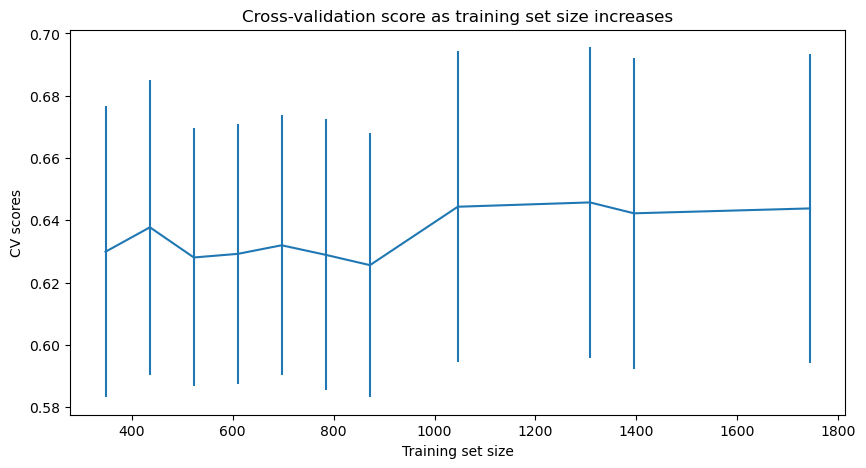

In [292]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that I seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 450-500.

Save best model object from pipeline

In [293]:
#Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [294]:
import pandas as pd
import os
import pickle
    
    
# This utility was created because students were getting confused when they ran 
# their notebooks twice, the previous write-to-file code would do nothing and say  
# nothing. The students thought the file was over-written when in fact, it was not -
# generating hidden bugs in subsequent notebooks.

def save_file(data, fname, dname):
    """Save a datafile (data) to a specific location (dname) and filename (fname)
    
    Currently valid formats are limited to CSV or PKL."""
    
    if not os.path.exists(dname):
        os.mkdir(dname)
        print(f'Directory {dname} was created.')
        
    fpath = os.path.join(dname, fname)
    
    
    if os.path.exists(fpath):
        print("A file already exists with this name.\n")

        yesno = None
        while yesno != "Y" and yesno != "N":
            yesno = input('Do you want to overwrite? (Y/N)').strip()[0].capitalize()
            if yesno == "Y":
                print(f'Writing file.  "{fpath}"')
                _save_file(data, fpath)
                break  # Not required
            elif yesno == "N":
                print('\nPlease re-run this cell with a new filename.')
                break  # Not required
            else:
                print('\nUnknown input, please enter "Y" or "N".')

    else:  # path does not exist, ok to save the file
        print(f'Writing file.  "{fpath}"')
        _save_file(data, fpath)
        
        
        
        
        
        
def _save_file(data, fpath):
    valid_ftypes = ['.csv', '.pkl']
    
    assert (fpath[-4:] in valid_ftypes), "Invalid file type.  Use '.csv' or '.pkl'"

    # Figure out what kind of file we're dealing with by name
    if fpath[-3:] == 'csv':
        data.to_csv(fpath, index=False)
    elif fpath[-3:] == 'pkl':
        with open(fpath, 'wb') as f:
            pickle.dump(data, f)
            

In [295]:
# save the model

modelpath = '../Models'
save_file(best_model, 'housing_pricing_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../Models\housing_pricing_model.pkl"


## Summary

Summary preprocessing and training

In this notebook I focused on pre-processing and training a model to obtain the Sold_Price ticket based on most significant listing features. To gain a baseline idea of performance of the model, first I use the average Sold_Price as a predictor and assess its performance. This first model represents the baseline performance comparison for subsequent models. 
To prevent data leakage, I removed the following columns:

    -	List_Price
    -	diff_List_Sold
    -	Price_per_SqFt

These columns contained the sold price, implicitly.

Next, I searched for NaN values in the dataset. HOA_Fee feature was the only one containin NaN values. I replaced those with zero. 

Next, I used dummy variables to turn 11 features with categorical values into numerical. The dataframe shape is now (3117, 64) for a total of 64 columns (features) 

Next, I partitioned the data in a training and a test data set using a 70/30 train/test split. Target variable is Sold_Price. 

The average Sold_Price is $649888 for trained data (X_train, y_train), calculated both with mean() method and by using DummyRegressor class from sklearn  calling (strategy = ‘mean’) This is a baseline to compare against.

**Metrics:**
To assess prediction errors. The R_squared, MAE and MSE metrics were considered and were calculated using both functions defining the metrics and the built in sklearn.metrics module 

#### First Metric considered: R-squared (coef of determination)

Using mean value of Sold_Price for `predict` method in scikit-learn (sklearn) I obtain a predicted Sold_Price value of 649888 (target value)

Evidently, if error between the mean value and predicted mean value is zero (649888 – 649888)
Therefore, the R_squared(y_train, y_tr_pred) = 0

Following the same steps on the test set, I obtain R_squared = -0.078 as expected, since the calculation is done on unseen data. 

#### Second Metric considered: MAE (Mean Absolute Error)

    mae(y_train, y_tr_pred) = 347574.78
    
    mae(y_test, y_te_pred) = 313711.92, 

which is surprisingly less then mae calculated on train data. This can be attributed to chance. A cross validation method performed on 1000 different train/test splits can shed more light on interpretation of this result.

#### Third Metric considered: MSE (Mean Squarred Error)

    mae(y_train, y_tr_pred) = 407213445225
    
    mae(y_test, y_te_pred) = 306122830945

same conclusion as for Mae.

### Initial Models

#### First model:  Linear Regression

To build models I have to process the dataframe by scaling, training the model, make predictions, and assess the model performance. 

Target values were predicted by linear regression model as `y_tr_pred` and `y_te_pred` for training and test data, respectively. 

Assessing the linear model performance by using the 3 metrics R_squared, MAE, and MSE, I get the results below:

    R_squared(y_train, y_tr_pred) = 0.678
    
    R_squared(y_test, y_te_pred) = 0.62
    

    mae(y_train, y_tr_pred) = 215710
    
    mae(y_test, y_te_pred) = 193058
    

    mse(y_train, y_tr_pred) = 130820474427
    
    mse(y_test, y_te_pred) = 115192399208
    

Next I use a pipeline to combine a sequence of data transformation steps. I use a features selection function in the pipeline to select the 5 best features. The feature ranking selection is performed using the f_regression statistical method (based on F-statistic)
Assessing the model performance by using the 3 metrics R_squared, MAE, and MSE

    R_squared(y_train, y_tr_pred) = 0.648
    
    R_squared(y_test, y_te_pred) = 0.595


    mae(y_train, y_tr_pred) = 218657
    
    mae(y_test, y_te_pred) = 199089


    mse(y_train, y_tr_pred) = 143050188547
    
    mse(y_test, y_te_pred) = 122793575291

These metrics results with 5 best features are worse than linear regression model where all features were used.

### Refining the Linear model (with the 5 best features)

To optimize model performance, I use 5 folds cross validation on the linear regression model with 5 best 5 features.
The 5 folds ‘test_score’ results are:

    array([0.6891245 , 0.6951945 , 0.66614678, 0.58246098, 0.586157  ])

 with a mean value of 0.64 and standard deviation of 0.049
A 95% confidence interval (plus minus 2 stdev) is 0.54 and 0.74.

### Hyperparameter search using GridSearchCV

The gridsearch found 8 best hyper parameters (best estimators) out of 62 features


#### Second model:  Random Forest

A 5 folds cross validation resulted in following cv_scores:

    array([0.77760362, 0.82047775, 0.81603759, 0.76456221, 0.64973281])

with a mean value of 0.76 and standard deviation of 0.061

### Hyperparameter search in Random Forest model using GridSearchCV

A total of 10 best estimators out of 63 features. 

A 5 folds cross validation resulted in following rf_cv_scores:

    array([0.77734116, 0.81865622, 0.81868139, 0.76498567, 0.65513212])

with a mean value of 0.76 and standard deviation of 0.059, only slight improvement in stdev.

### Final Model selection

Using negative of mean absolute error
Linear regression: 

    mean test scores: 223020, 
    
    mean stdev = 6665
    
    mae = 192875


Random Forest regression performance test: 

    mean test scores: 129268, 
    
    mean stdev = 5195
    
    mae = 101292

The random forest model has a lower cross-validation mean absolute error by almost $90000. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

### Data quantity assessment
Cross validation score as training set size increases shows  I seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 450-500.
